# Section 1: Generating Data

Generating our data: a small dataset with in-distribution (IND) datapoints and a clearly separated out-of-distribution (OOD) cluster that we will use to test our models performance on unseen data. 

In [1]:
# 1. imports and set-up

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 

plt.rcParams['figure.figsize'] = (6.2, 5.2)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

rng = np.random.RandomState(42)


# 2. generate our IND data - two interlocking half circles (moons)
X_all, y_all = make_moons(n_samples=600, noise=0.2, random_state=rng)

X_train, X_ind_test, y_train, y_ind_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=rng, stratify=y_all
)


# 3. generate OOD data - separate gaussian cluster
X_ood = rng.normal(loc=[3.4, 3.0], scale=[0.35, 0.35], size=(120, 2))


# 4. print shape summary
print("Shapes:",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)


Shapes: Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


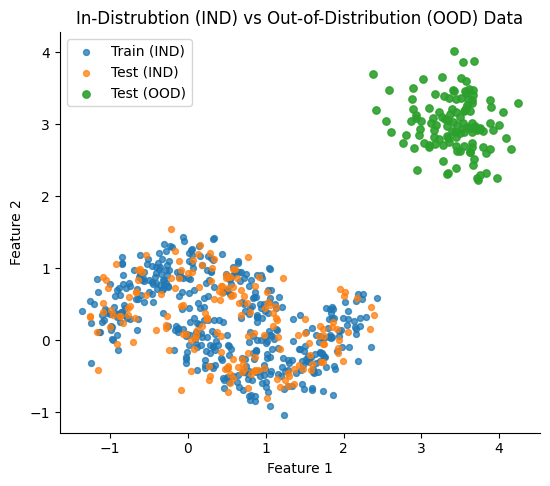

In [2]:
X_train_plot = X_train
X_test_plot = X_ind_test

fig, ax = plt.subplots()

ax.scatter(X_train_plot[:, 0], X_train_plot[:, 1], s=18, label='Train (IND)', alpha=0.75)
ax.scatter(X_test_plot[:, 0], X_test_plot[:, 1], s=18, label='Test (IND)', alpha=0.75)
ax.scatter(X_ood[:, 0], X_ood[:, 1], s=28, label='Test (OOD)', alpha=0.9)

ax.set_title("In-Distrubtion (IND) vs Out-of-Distribution (OOD) Data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()

In [3]:
import os, joblib 

os.makedirs("artifacts", exist_ok=True)

# save arrays
np.save("artifacts/X_train.npy", X_train)
np.save("artifacts/y_train.npy", y_train)
np.save("artifacts/X_ind_test.npy", X_ind_test)
np.save("artifacts/y_ind_test.npy", y_ind_test)
np.save("artifacts/X_ood.npy", X_ood)

# save as a csv for easy viewing and also for streamlit demos 
pd.DataFrame(np.c_[X_train, y_train], columns=["x1", "x2", "y"]).to_csv("artifacts/train_data.csv", index=False)
pd.DataFrame(np.c_[X_ind_test, y_ind_test], columns=["x1", "x2", "y"]).to_csv("artifacts/test_ind_data.csv", index=False)
pd.DataFrame(X_ood, columns=["x1", "x2"]).to_csv("artifacts/ood_data.csv", index=False)

print("Saved data to artifacts/ folder")

Saved data to artifacts/ folder


In [4]:
def describe(name, X):
    m = X.mean(axis=0)
    s = X.std(axis=0)
    print(f"{name:>10s} | mean: {m[0]:.3f}, {m[1]:.3f} | std: {s[0]:.3f}, {s[1]:.3f}")


describe("Train", X_train)
describe("IND Test", X_ind_test)
describe("OOD Test", X_ood)

     Train | mean: 0.506, 0.270 | std: 0.904, 0.545
  IND Test | mean: 0.504, 0.267 | std: 0.883, 0.526
  OOD Test | mean: 3.420, 3.005 | std: 0.358, 0.368


# Section 2: Logistic regression baseline classifier

Build a baseline classifier (logistic regression) and see why its overconfident on OOD.

Logistic regression:
- computes a linear score (describes how likely it is for a datapoint to fit into a class)
- pass it through a **sigmoid** function - an S-shaped curve 
- the sigmoid "translates" our score into a probability
- if the score is very positive or very negative, the sigmoid satures near 1 or 0 -- i.e. high confidence

-> objective: notice that our model will have high confidence even on data thats far from the training distribution

**WARNING:** overconfidence on unfamiliar inputs 

In [5]:
from pathlib import Path

ART = Path("artifacts")
rng = np.random.RandomState(42)

def load_data():
    if (ART / "X_train.npy").exists():
        X_train = np.load(ART / "X_train.npy")
        y_train = np.load(ART / "y_train.npy")
        X_ind_test = np.load(ART / "X_ind_test.npy")
        y_ind_test = np.load(ART / "y_ind_test.npy")
        X_ood = np.load(ART / "X_ood.npy")
        print("Loaded data from artifacts/")
    else:
        raise FileNotFoundError("Data not found. Please run detection.ipynb to generate data.")
    return X_train, y_train, X_ind_test, y_ind_test, X_ood

X_train, y_train, X_ind_test, y_ind_test, X_ood = load_data()
print("Shapes:",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)

Loaded data from artifacts/
Shapes: Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(
    StandardScaler(), # puts our features on comparable scales
    LogisticRegression(random_state=rng) # logistic regression model
)

clf.fit(X_train, y_train)
print("Trained model.")

Trained model.


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_ind = clf.predict(X_ind_test)
acc = accuracy_score(y_ind_test, y_pred_ind)
print(f"IND Test Accuracy: {acc:.3f}")
print(f"Classification Report:\n{classification_report(y_ind_test, y_pred_ind)}")
cm = confusion_matrix(y_ind_test, y_pred_ind)
print(f"Confusion Matrix:\n{cm}")

IND Test Accuracy: 0.872
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        90
           1       0.89      0.86      0.87        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180

Confusion Matrix:
[[80 10]
 [13 77]]


C:\Users\AbdulHafeez\AppData\Local\Temp\ipykernel_6388\870393685.py:21: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy, probs, levels=[0.5], colors='black', linestyles='--', linewidths=2, label='Decision Boundary')


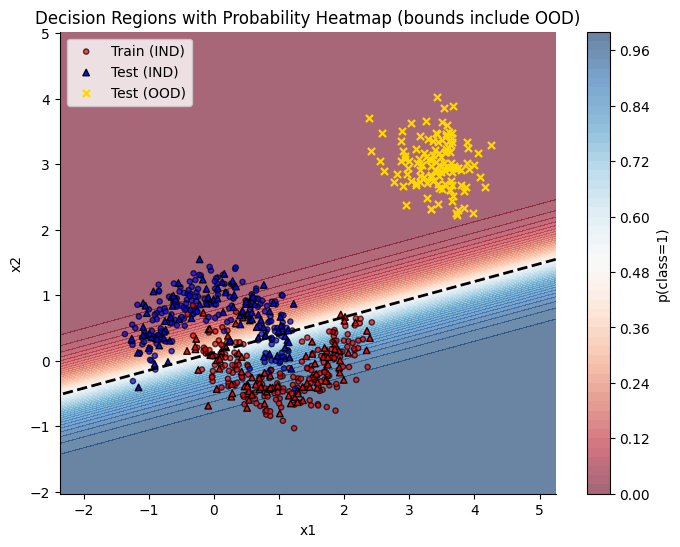

In [8]:
# construct bounds that include train and OOD data
X_for_bounds = np.vstack([X_train, X_ood])
pad = 1.0

x_min, x_max = X_for_bounds[:, 0].min() - pad, X_for_bounds[:, 0].max() + pad
y_min, y_max = X_for_bounds[:, 1].min() - pad, X_for_bounds[:, 1].max() + pad

# grid of points across this rectangle 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# predict probability of class 1 for each point in the grid
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

# plotting 
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
cbar = plt.colorbar(contour)
cbar.set_label("p(class=1)")

plt.contour(xx,yy, probs, levels=[0.5], colors='black', linestyles='--', linewidths=2, label='Decision Boundary')

plt.scatter(X_train[:, 0], X_train[:, 1],
            c=y_train, cmap="bwr", s=14, edgecolor="k", alpha=0.70, label="Train (IND)")
plt.scatter(X_ind_test[:, 0], X_ind_test[:, 1],
            c=y_ind_test, cmap="bwr", s=22, marker="^", edgecolor="k", alpha=0.95, label="Test (IND)")
plt.scatter(X_ood[:, 0], X_ood[:, 1],
            c="gold", s=26, marker="x", linewidths=1.6, label="Test (OOD)")

plt.title("Decision Regions with Probability Heatmap (bounds include OOD)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

Median IND confidence: 0.917
Median OOD confidence: 1.000


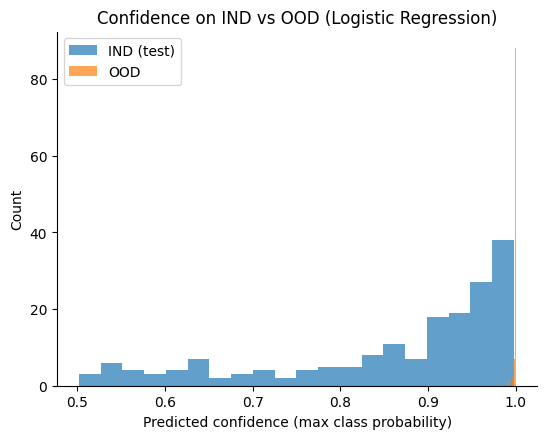

Fraction of OOD with confidence ≥ 0.95: 100.00%


In [9]:
# --- Compare predicted confidence on IND vs OOD ---

# For each point, the model predicts p(class=1) and p(class=0) = 1 - p1
proba_ind = clf.predict_proba(X_ind_test)  # shape: [N, 2]
proba_ood = clf.predict_proba(X_ood)       # shape: [M, 2]

# Take the chosen class probability (max over classes) as the model's "confidence"
conf_ind = proba_ind.max(axis=1)
conf_ood = proba_ood.max(axis=1)

print(f"Median IND confidence: {np.median(conf_ind):.3f}")
print(f"Median OOD confidence: {np.median(conf_ood):.3f}")

# Visualize distributions
plt.figure(figsize=(6.2, 4.6))
plt.hist(conf_ind, bins=20, alpha=0.70, label="IND (test)")
plt.hist(conf_ood, bins=20, alpha=0.70, label="OOD")
plt.xlabel("Predicted confidence (max class probability)")
plt.ylabel("Count")
plt.title("Confidence on IND vs OOD (Logistic Regression)")
plt.legend()
plt.show()

# What fraction of OOD is assigned very high confidence?
high_thr = 0.95
print(f"Fraction of OOD with confidence ≥ {high_thr:.2f}: {(conf_ood >= high_thr).mean():.2%}")

In [10]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(clf, "artifacts/logreg_baseline.pkl")
print("Saved model to artifacts/logreg_baseline.pkl")

Saved model to artifacts/logreg_baseline.pkl


# Section 3: Temperature scaling and calibration

- confidence = model's own predicted probability for its chosen class
- predictive uncertainty = the idea of how unsure the model is about the label 

logistic model's confidence comes from the sigmoid of a linear score - NOT FROM MODEL IGNORANCE - can be very overconfident

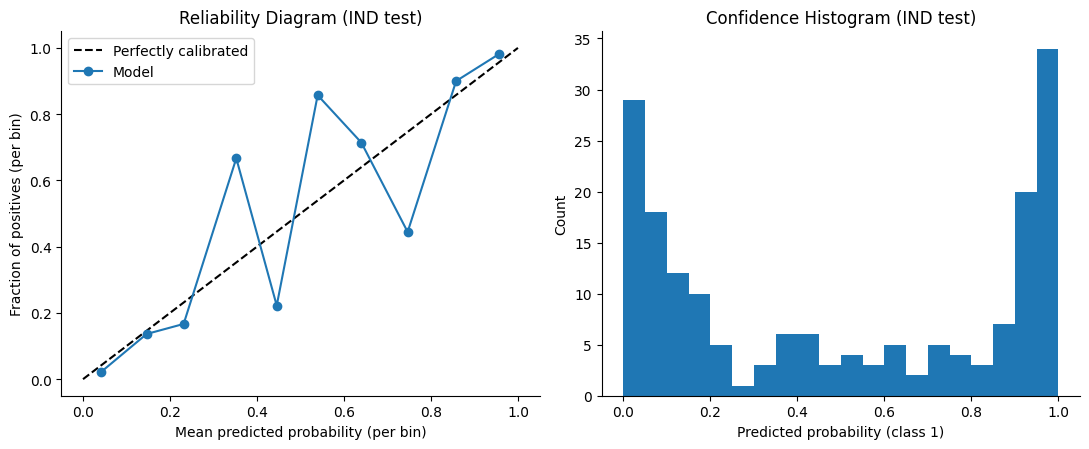

IND test — Accuracy: 0.872 | ECE: 0.0756 | NLL: 0.301 | Brier: 0.0956


In [11]:
# --- Reliability diagram + ECE on IND test ---

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score

# Get predicted probabilities for positive class on IND test
y_prob_test = clf.predict_proba(X_ind_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

# Compute points for the reliability diagram
prob_true, prob_pred = calibration_curve(y_ind_test, y_prob_test, n_bins=10, strategy='uniform')

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    ECE with uniform bins in [0,1]. Lower is better.
    """
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        mask = bin_ids == b
        if np.any(mask):
            conf = np.mean(y_prob[mask])
            acc  = np.mean(y_true[mask])
            ece += np.abs(acc - conf) * (mask.sum() / total)
    return ece

ece_before   = expected_calibration_error(y_ind_test, y_prob_test, n_bins=10)
nll_before   = log_loss(y_ind_test, y_prob_test)         # negative log-likelihood
brier_before = brier_score_loss(y_ind_test, y_prob_test) # prob. accuracy
acc_test     = accuracy_score(y_ind_test, y_pred_test)

# Plot reliability diagram + confidence histogram
fig, ax = plt.subplots(1, 2, figsize=(11,4.6))

# Reliability curve
ax[0].plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
ax[0].plot(prob_pred, prob_true, 'o-', label='Model')
ax[0].set_xlabel('Mean predicted probability (per bin)')
ax[0].set_ylabel('Fraction of positives (per bin)')
ax[0].set_title('Reliability Diagram (IND test)')
ax[0].legend(loc='upper left')

# Confidence histogram
ax[1].hist(y_prob_test, bins=20, range=(0,1))
ax[1].set_xlabel("Predicted probability (class 1)")
ax[1].set_ylabel("Count")
ax[1].set_title("Confidence Histogram (IND test)")

plt.tight_layout()
plt.show()

print(f"IND test — Accuracy: {acc_test:.3f} | ECE: {ece_before:.4f} | NLL: {nll_before:.3f} | Brier: {brier_before:.4f}")

In [12]:
# --- Build a calibration split and fit temperature T by grid search (no SciPy needed) ---

from sklearn.model_selection import train_test_split

# Split a small calibration set from the original training fold (IND).
# Note: The model was trained on X_train already. For a purist split, re-train on a subset and hold out calib.
X_train_sub, X_calib, y_train_sub, y_calib = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Get logits for calibration set:
# For logistic regression, decision_function returns a signed score (logit for the positive class)
z_calib = clf.decision_function(X_calib)
z_test  = clf.decision_function(X_ind_test)  # we'll apply T here after fitting

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll_binary(y_true, p):
    """
    Binary negative log-likelihood = -[y*log(p) + (1-y)*log(1-p)], averaged.
    We clip to avoid log(0).
    """
    eps = 1e-12
    p = np.clip(p, eps, 1-eps)
    return -np.mean(y_true*np.log(p) + (1-y_true)*np.log(1-p))

# Simple 1D grid search for T in [0.2, 5.0]
T_grid = np.linspace(0.2, 5.0, 60)
nlls   = []
for T in T_grid:
    pT = sigmoid(z_calib / T)
    nlls.append(nll_binary(y_calib, pT))

best_T = float(T_grid[int(np.argmin(nlls))])
print(f"Chosen temperature T = {best_T:.3f} (minimizes NLL on calibration set)")

# Apply to test
p_test_before = sigmoid(z_test)          # original (T=1)
p_test_after  = sigmoid(z_test / best_T) # temperature-scaled

Chosen temperature T = 1.258 (minimizes NLL on calibration set)


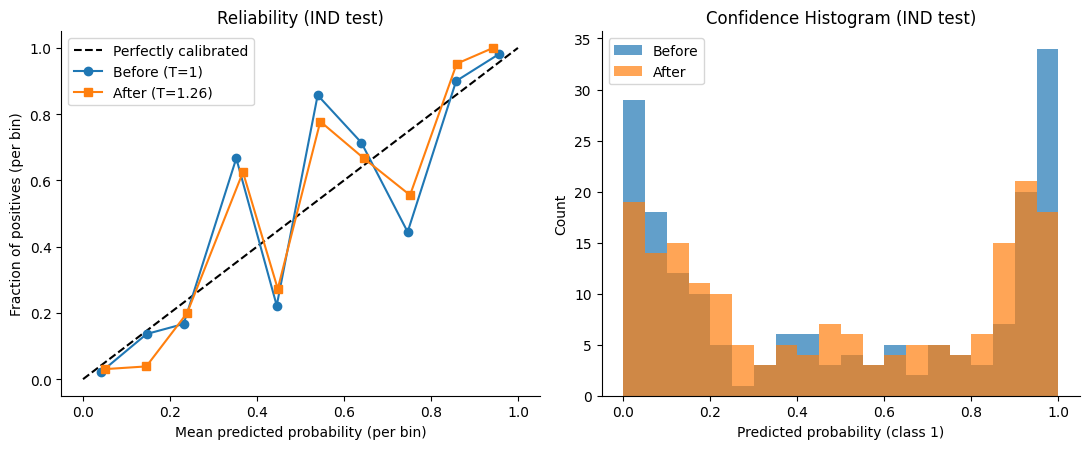

IND test metrics:
  ECE   before: 0.0756 | after: 0.0903
  NLL   before: 0.301 | after: 0.314
  Brier before: 0.0956 | after: 0.0967


In [24]:
# --- Reliability + metrics before vs after temperature scaling ---

prob_true_b, prob_pred_b = calibration_curve(y_ind_test, p_test_before, n_bins=10, strategy='uniform')
prob_true_a, prob_pred_a = calibration_curve(y_ind_test, p_test_after,  n_bins=10, strategy='uniform')

ece_after   = expected_calibration_error(y_ind_test, p_test_after, n_bins=10)
nll_after   = nll_binary(y_ind_test, p_test_after)
brier_after = ((y_ind_test - p_test_after)**2).mean()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(11,4.6))

# Reliability curves
ax[0].plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
ax[0].plot(prob_pred_b, prob_true_b, 'o-', label='Before (T=1)')
ax[0].plot(prob_pred_a, prob_true_a, 's-', label=f'After (T={best_T:.2f})')
ax[0].set_xlabel('Mean predicted probability (per bin)')
ax[0].set_ylabel('Fraction of positives (per bin)')
ax[0].set_title('Reliability (IND test)')
ax[0].legend(loc='upper left')

# Confidence histogram (before vs after)
ax[1].hist(p_test_before, bins=20, range=(0,1), alpha=0.7, label="Before")
ax[1].hist(p_test_after,  bins=20, range=(0,1), alpha=0.7, label="After")
ax[1].set_xlabel("Predicted probability (class 1)")
ax[1].set_ylabel("Count")
ax[1].set_title("Confidence Histogram (IND test)")
ax[1].legend()

plt.tight_layout()
plt.show()

print(f"IND test metrics:")
print(f"  ECE   before: {ece_before:.4f} | after: {ece_after:.4f}")
print(f"  NLL   before: {nll_before:.3f} | after: {nll_after:.3f}")
print(f"  Brier before: {brier_before:.4f} | after: {brier_after:.4f}")

OOD median confidence before: 1.000
OOD median confidence after : 0.999


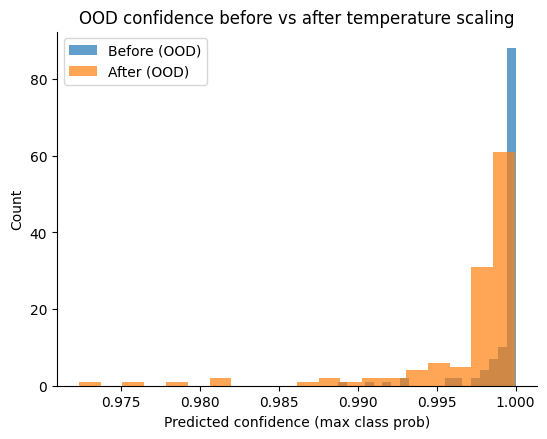

In [13]:
# --- Check OOD confidence before vs after temperature scaling ---

z_ood = clf.decision_function(X_ood)
p_ood_before = sigmoid(z_ood)
p_ood_after  = sigmoid(z_ood / best_T)

conf_ood_before = np.maximum(p_ood_before, 1 - p_ood_before)
conf_ood_after  = np.maximum(p_ood_after,  1 - p_ood_after)

print(f"OOD median confidence before: {np.median(conf_ood_before):.3f}")
print(f"OOD median confidence after : {np.median(conf_ood_after):.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6.2, 4.6))
plt.hist(conf_ood_before, bins=20, alpha=0.7, label="Before (OOD)")
plt.hist(conf_ood_after,  bins=20, alpha=0.7, label="After (OOD)")
plt.xlabel("Predicted confidence (max class prob)")
plt.ylabel("Count")
plt.title("OOD confidence before vs after temperature scaling")
plt.legend()
plt.show()

# Section 4: Bayesian Logistic Regression

Bayesian Logistic Regression (posterior predictive) - "BLR"

- stay "cautious" on unfamiliar (OOD) inputs. 
- helps us deal with epistemic uncertainty - i.e. it will maintain uncertainty for data that is *different* to what its seen already


Logistic regression: picks ONE best set of weights. BLR keeps a distribution of **plausible weights**. When data (inputs) look unfamiliar, many weight settings are plausible - averaging predictions gives **less extreme probabilities** (closer to 0.5) -> we also get higher spread across samples ("epistemic uncertainty").




In [14]:
SEED = 42
GRID_RES = 230
POST_SAMPLES = 400 
PAD = 1.0 

In [15]:
def make_blr_predictor_linear_2d(X_train, y_train, seed=SEED, advi_steps=5000, post_samples = POST_SAMPLES):
    """
    Linear (2D) BLR only: StandardScaler -> BLR. Returns a predictor bound to the SAME preprocessor,
    plus the preprocessor and idata. Prints dims at fit & predict time.
    """
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    import pymc as pm, arviz as az

    rng = np.random.default_rng(seed)

    # Preprocessor: StandardScaler ONLY (=> 2 features)
    preproc = StandardScaler().fit(X_train)
    Xs = preproc.transform(X_train)
    D = Xs.shape[1]
    print(f"[BLR FIT] feature dim D = {D} (expected 2)")

    with pm.Model() as blr:
        w = pm.Normal("w", 0.0, 2.0, shape=D)
        b = pm.Normal("b", 0.0, 2.0)
        eta = pm.math.dot(Xs, w) + b
        p   = pm.math.sigmoid(eta)
        yobs = pm.Bernoulli("yobs", p=p, observed=y_train)

        approx = pm.fit(
            n=advi_steps, method="advi", random_seed=seed,
            progressbar=True, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)]
        )
        idata = approx.sample(max(post_samples, 300), random_seed=seed)

    # Quick posterior dim print
    sel = az.extract(idata, group="posterior")
    W = sel["w"].values
    if W.ndim > 2: W = W.reshape(-1, W.shape[-1])
    print(f"[BLR FIT] posterior w shape = {W.shape}  (S, D)")

    def predict_mean_std(X, nsamples=post_samples):
        import numpy as np, arviz as az
        Xz = preproc.transform(X)
        print(f"[BLR PRED] X transformed dim = {Xz.shape[1]} (should match posterior D)")

        sel = az.extract(idata, group="posterior")
        W = sel["w"].values; B = sel["b"].values
        if W.ndim > 2: W = W.reshape(-1, W.shape[-1])
        if B.ndim > 1: B = B.ravel()
        print(f"[BLR PRED] posterior w dim = {W.shape[-1]}")

        if Xz.shape[1] != W.shape[-1]:
            raise ValueError(f"[BLR PRED] Feature mismatch: X has {Xz.shape[1]} cols, "
                             f"posterior w has {W.shape[-1]}.\n"
                             f"This predictor is linear-2D. Restart kernel or refit to fix stale state.")

        S_total = W.shape[0]
        S = min(int(nsamples), S_total)
        idx = np.random.default_rng(seed).choice(S_total, size=S, replace=False)
        W = W[idx]; B = B[idx]
        logits = Xz @ W.T + B[None, :]
        P = 1/(1+np.exp(-logits))
        return P.mean(axis=1), P.std(axis=1)

    return predict_mean_std, preproc, idata

In [16]:
predict_blr, preproc_blr, idata_blr = make_blr_predictor_linear_2d(
    X_train, y_train, seed=42, advi_steps=5000, post_samples=400
)

[BLR FIT] feature dim D = 2 (expected 2)


c:\workspace\outlier-detection\venv\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


c:\workspace\outlier-detection\venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Finished [100%]: Average Loss = 153.81


[BLR FIT] posterior w shape = (2, 400)  (S, D)


In [17]:
def _posterior_WB(idata, nsamples=None, seed=42):
    """
    Make posterior matrices dimension-agnostic.
    Returns:
      W: (S, D)  posterior samples of weights
      B: (S,)    posterior samples of intercept
    """
    import numpy as np

    w_da = idata.posterior["w"]  # xarray.DataArray
    # Identify the parameter (feature) dim: anything not chain/draw/sample
    param_dims = [d for d in w_da.dims if d not in ("chain", "draw", "sample")]
    if len(param_dims) != 1:
        raise ValueError(f"Can't identify weight param dim; got dims {w_da.dims}")
    pdim = param_dims[0]

    # Build a unified 'sample' dim by stacking chain/draw if needed, then put (sample, param)
    if "sample" in w_da.dims:
        w_da_s = w_da.transpose("sample", pdim)
    else:
        dims_to_stack = tuple(d for d in ("chain", "draw") if d in w_da.dims)
        if len(dims_to_stack) == 0:
            # Already only the param dim — treat each entry as a single sample
            w_da_s = w_da.expand_dims(sample=["s0"]).transpose("sample", pdim)
        else:
            w_da_s = w_da.stack(sample=dims_to_stack).transpose("sample", pdim)

    W = w_da_s.values  # (S_total, D)

    # Intercept b: just stack to 'sample' and flatten
    b_da = idata.posterior["b"]
    if "sample" in b_da.dims:
        B = b_da.transpose("sample", ...).values
    else:
        dims_to_stack = tuple(d for d in ("chain", "draw") if d in b_da.dims)
        if len(dims_to_stack) == 0:
            B = b_da.expand_dims(sample=["s0"]).values
        else:
            B = b_da.stack(sample=dims_to_stack).values
    B = B.reshape(-1)  # (S_total,)

    # Optional subsampling of posterior draws
    if nsamples is not None and W.shape[0] > nsamples:
        rng = np.random.default_rng(seed)
        idx = rng.choice(W.shape[0], size=int(nsamples), replace=False)
        W = W[idx]
        B = B[idx]

    return W, B


In [18]:
def posterior_predictive_proba(Xs, idata, nsamples=400, seed=42):
    """
    Xs must be transformed with the SAME preprocessor used at BLR fit time (e.g., scaler_blr).
    Returns:
      mean_p: (N,)
      std_p : (N,)
    """
    import numpy as np

    W, B = _posterior_WB(idata, nsamples=nsamples, seed=seed)  # W: (S,D), B: (S,)
    # Strict shape check:
    if Xs.shape[1] != W.shape[1]:
        raise ValueError(f"Feature mismatch: X has {Xs.shape[1]} cols, posterior w has {W.shape[1]}.")

    # recommend learning einops/einsum for this kind of thing
    logits = Xs @ W.T + B[None, :]        # (N,S)
    P = 1.0 / (1.0 + np.exp(-logits))     # (N,S)
    return P.mean(axis=1), P.std(axis=1)


C:\Users\AbdulHafeez\AppData\Local\Temp\ipykernel_6388\2782288391.py:35: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[1].scatter(X_ood[:,0],   X_ood[:,1],   s=18, marker="x", c="white", edgecolor="k", label="OOD")


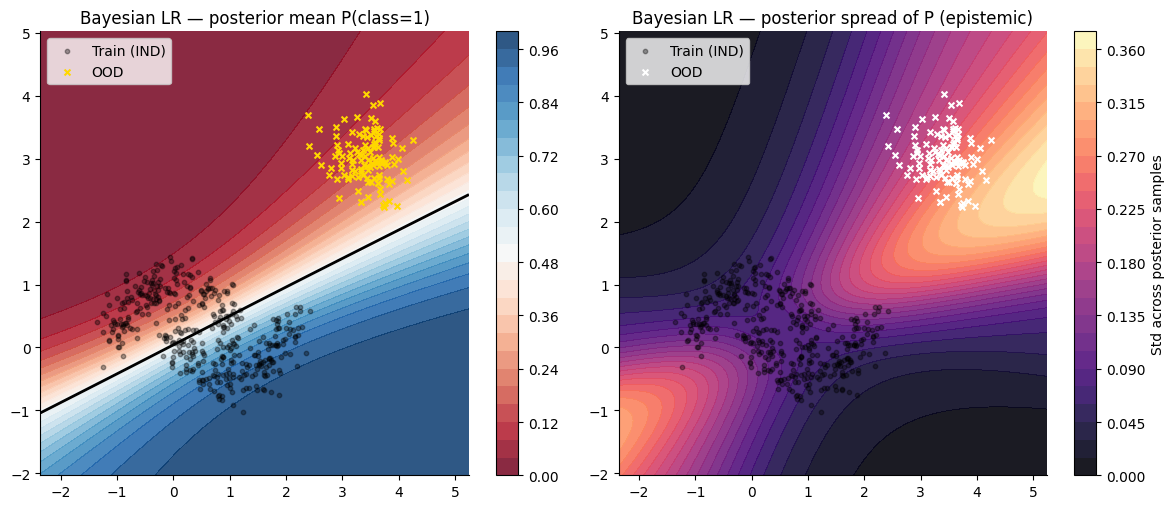

In [19]:
# If you followed the linear-2D path, ensure you're using THAT scaler:
from sklearn.preprocessing import StandardScaler
scaler_blr = StandardScaler().fit(X_train)
Xtr_s  = scaler_blr.transform(X_train)
Xte_s  = scaler_blr.transform(X_ind_test)
Xood_s = scaler_blr.transform(X_ood)

# Grid (include OOD)
Xb = np.vstack([X_train, X_ood])
x_min, x_max = Xb[:,0].min()-PAD, Xb[:,0].max()+PAD
y_min, y_max = Xb[:,1].min()-PAD, Xb[:,1].max()+PAD

xx, yy = np.meshgrid(np.linspace(x_min, x_max, GRID_RES),
                     np.linspace(y_min, y_max, GRID_RES))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_s = scaler_blr.transform(grid)  # ← 2 columns

# Predict (now robust to axis ordering in idata)
mean_p_grid, std_p_grid = posterior_predictive_proba(grid_s, idata_blr, nsamples=400)

# Plots
import matplotlib.pyplot as plt
m = mean_p_grid.reshape(xx.shape)
s = std_p_grid.reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,5.2))
cb0 = ax[0].contourf(xx, yy, m, levels=30, cmap="RdBu", alpha=0.85)
ax[0].contour(xx, yy, m, levels=[0.5], colors="k", linewidths=2)
ax[0].scatter(X_train[:,0], X_train[:,1], s=10, c="k", alpha=0.35, label="Train (IND)")
ax[0].scatter(X_ood[:,0],   X_ood[:,1],   s=18, marker="x", c="gold", label="OOD")
ax[0].set_title("Bayesian LR — posterior mean P(class=1)"); ax[0].legend(loc="upper left"); plt.colorbar(cb0, ax=ax[0])

cb1 = ax[1].contourf(xx, yy, s, levels=30, cmap="magma", alpha=0.9)
ax[1].scatter(X_train[:,0], X_train[:,1], s=10, c="k", alpha=0.35, label="Train (IND)")
ax[1].scatter(X_ood[:,0],   X_ood[:,1],   s=18, marker="x", c="white", edgecolor="k", label="OOD")
ax[1].set_title("Bayesian LR — posterior spread of P (epistemic)"); ax[1].legend(loc="upper left")
plt.colorbar(cb1, ax=ax[1], label="Std across posterior samples")
plt.tight_layout(); plt.show()
